# Imports required

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

# !pip install deap

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import operator
import random

import math

Loading in CIFAR-10

In [ ]:
# The dataset comes in data of the range 0-1, we want to convert this to -1 to 1 as part of normalisation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Function to transform the dataset to the specified range

batch_size = 512

# Downloading the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Loading the training set into a variable
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# etc.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Specifying the classes of the dataset that we want to train the classifier on
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Testing for GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Testing to see if we can see the images

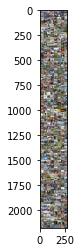

frog  ship  truck car   car   frog  ship  truck ship  deer  ship  cat   plane cat   dog   plane plane deer  car   cat   bird  truck bird  truck cat   cat   cat   cat   horse frog  ship  dog   horse cat   car   cat   cat   frog  frog  deer  truck ship  horse bird  horse dog   plane deer  bird  car   horse truck bird  cat   car   deer  frog  horse cat   deer  truck ship  plane car   cat   dog   ship  cat   car   bird  cat   ship  truck plane bird  car   cat   ship  ship  cat   deer  dog   truck car   truck ship  frog  dog   cat   ship  truck frog  car   car   frog  bird  car   horse deer  truck dog   deer  car   dog   bird  dog   frog  truck frog  car   dog   plane cat   bird  dog   cat   bird  ship  car   frog  truck cat   bird  plane cat   truck horse truck car   bird  frog  truck frog  dog   truck dog   bird  frog  truck ship  ship  cat   dog   car   frog  cat   plane car   deer  frog  deer  horse plane ship  plane truck truck bird  plane ship  cat   car   frog  cat   deer  frog  car 

In [ ]:
# functions to show an image for fun


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Building network definition

In [ ]:
# Relu is a fast output function

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)

        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net()

In [ ]:
# Upload GD_Model.pth to the session to act as pre-defined network
# from google.colab import files
# files.upload()

Loading in the model

In [ ]:
PATH = ('./GD_Model.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Setting all layers to not change their weights with GD backpropagation

for param in PopModel.parameters():
    # By setting the requires grad for each parameter to false, we no longer track it with autograd
    # Consequently, backpropagation or whatever will not compute the gradients for these layers
    param.requires_grad = False

Getting the final layer

In [ ]:
finalLayer = list(PopModel.children())[-1]

print(finalLayer) # 10 features out

print(len(finalLayer.weight)) # 10 population size


print(len(finalLayer.weight[0])) # 10 arrays, with 84 items in it

# 84 inputs connected to a single output, there are 10 outputs therefore 84x10 connections in total. for one output, the 84 connections will have 84 different weights which are used
# to calculate the output node. therefore there are 10 tensors with 84 elements in each tensor, with a different set of weights.

# print(finalLayer.weight)

#print(finalLayer.weight) # Layer requires 840 connections

print(len(finalLayer.bias))

paramCount = sum(param.numel() for param in finalLayer.parameters())

print(paramCount) # 850 Parameters: 840 weights + 10 biases

sk= torch.max(((finalLayer.weight).reshape(840,)))

print(sk)

Linear(in_features=84, out_features=10, bias=True)
10
84
10
850
tensor(0.4984)


In [ ]:
# Randomise final layer weights



nn.init.xavier_uniform(finalLayer.weight)

#print(finalLayer.weight)

print((finalLayer.weight).shape) # Shape that the layer requires is (10,84)

print((finalLayer.bias).shape)

torch.Size([10, 84])
torch.Size([10])


<ipython-input-11-0638b396f9c2>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(finalLayer.weight)


In [ ]:
# Converting weights to a numpy array

def convert_np_function(self, intermediate_tensor):
        intermediate_value = intermediate_tensor.numpy()
        self.intermediate_values.append(intermediate_value)

populationList = finalLayer.weight.numpy()

#print(populationList) # Converted to Numpy

Defining PSO functions

In [ ]:
posMinInit      = -3
posMaxInit      = + 5
VMaxInit        = 1.5
VMinInit        = 0.5
# populationSize  = 10
dimension       = 850
populationSize  = 100+int(dimension/10) # from lab on SL-PSO
interval        = 10
iterations      = 100

#variables used in SL-PSO
epsilon = dimension/100.0*0.01 # social influence of swarm centre

#Parameter setup -- these are not used in SL-PSO
wmax = 0.9 #weighting
wmin = 0.4
c1   = 2.0
c2   = 2.0

# Criterion for measuring loss, may need to tweak this to return negative value for PSO
criterion = nn.CrossEntropyLoss()

In [ ]:
# function to get the mean positions of the inviduals (swarm centre)
def getcenter(pop):
    center=list()
    for j in range(dimension): # count through dimensions
        centerj = 0
        for i in pop: # for each particle
            centerj += i[j] # sum up position in dimention j
        centerj /= populationSize # Average
        center.append(centerj)
    return center

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)

/vol/hpc-software/software/Anaconda3/2020.07/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/vol/hpc-software/software/Anaconda3/2020.07/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
# particle rerpresented by list of 5 things
# 1. fitness of the particle,
# 2. speed of the particle which is also going to be a list,
# 3.4. limit of the speed value,
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size))
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

def updateParticle(part,pop,center,i):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    r3 = random.uniform(0, 1)

    #Randomly choose a demonstrator for particle i from any of particles 0 to i-1, the Particle i
    #updates its velocity by learning from the demonstrator and the mean position of the swarm
    demonstrator=random.choice(list(pop[0:i]))

    for j in range(dimension): # count through dimensions
        part.speed[j]=r1*part.speed[j]+r2*(demonstrator[j]-part[j])+r3*epsilon*(center[j]-part[j])
        part[j]=part[j]+part.speed[j]

In [ ]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)

# Note most likely need to change the evaluate function
toolbox.register("evaluate", benchmarks.sphere) #sphere function is built-in in DEAP

# def sphere(individual):
#     r"""Sphere test objective function.

#     .. list-table::
#        :widths: 10 50
#        :stub-columns: 1

#        * - Type
#          - minimization
#        * - Range
#          - none
#        * - Global optima
#          - :math:`x_i = 0, \forall i \in \lbrace 1 \ldots N\rbrace`, :math:`f(\mathbf{x}) = 0`
#        * - Function
#          - :math:`f(\mathbf{x}) = \sum_{i=1}^Nx_i^2`
#     """
#     return sum(gene * gene for gene in individual), # How does this work?, return one value or return a list?

# the line above returns one value

runCounter = 0

def modelEval(particle, runCounter):
    runCounter = runCounter
    runCounter +=1
    #print("hello!")

    # First step to get the particles weights out from it, convert to an numpy array
    particleweightsNP1 = np.array(particle)

    particleweightsNP = particleweightsNP1[:840]
    biases = np.array(particleweightsNP1[-10:])

    # Putting biases straight in
    biases = torch.from_numpy(biases).float()
    finalLayer.bias = torch.nn.Parameter(biases.float())

    #print(particleweightsNP)

#     print("Shape of particle: " + str(particleweightsNP.shape))

    # Converting to the correct shape!
    reshapedWeights = particleweightsNP.reshape(10,84)
#     print("Shape of reshaped particle: " + str(reshapedWeights.shape))

    # Convert to torch array!
    torchWeights = torch.from_numpy(reshapedWeights).float()

    # Now we want to set the weights of the finalLayer to these weights

    finalLayer.weight = torch.nn.Parameter(torchWeights.float())

    # print("After:\n")
    # print(finalLayer.weight)

    #finalLayer.weight.data = torchWeights.float()
    #print(finalLayer.weight) # Note that the numbers look different than torchWeights ?
    #print(torchWeights)

    # Run a training loop for the model, with the particles weights set to the final layer and return a loss value back

    epoch_loss = 0.0
    running_loss = 0.0

    # reshapedWeights.to(device)
    # torchWeights.to(device)

#     print(f"Starting training run {runCounter}...")

    PopModel.to(device)

    for epoch in range(1):

        epoch_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # Getting the predictions for the model
            outputs = PopModel(inputs)

            loss = criterion(outputs, labels)

            #print(loss.item())

            epoch_loss += loss.item()

#         print("End of Epoch:" + str(epoch))

        running_loss += (epoch_loss / i)

    # Now we have a loss value:
    print("Total Loss: " + str(running_loss))

    return running_loss, # This may be the wrong this to pass back, one test run showed loss is 835852, remember to check that it definitely doesnt update through gradient!

    # High loss could be due to how the weights were initialised or how they were converted between numpy and torch tensor?

    # We need to return one value

    #object of type 'NoneType' has no len() # Error when not returning anything.
    #object of type 'float' has no len() # Error when returning_loss by itself, investigate the output of the original sphere function?

    # Original loss function returns a single value. example output looks like (136.3042681576523,)

    # Do you need to return a list, with each epoch loss in there?
    # Doing this: Assigned values have not the same length than fitness weights
    # Update: Do not return a list

toolbox.register("evaluate2", modelEval)

In [ ]:
def main():
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    #intialize the learning probabilities
    prob=[0]*populationSize
    for i  in range(len(pop)):
        prob[populationSize - i - 1] = 1 - i/(populationSize - 1)
        prob[populationSize - i - 1] = pow(prob[populationSize - i - 1], math.log(math.sqrt(math.ceil(dimension/100.0))))

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    #begin main loop
    for g in range(iterations):

        for part in pop:
            part.fitness.values = toolbox.evaluate2(part, runCounter) #actually only one fitness value

        #Sort the individuals in the swarm in ascending order. i.e., particle 0 is the best
        pop.sort(key=lambda x: x.fitness, reverse=True)
        #calculate the center (mean value) of the swarm
        center = getcenter(pop)

        for i  in reversed(range(len(pop)-1)):  # start with worst particle, and go in reverse towards best
                                                # don't do element 0 (best). Hence the i+1 below.
            if random.uniform(0, 1)<prob[i+1]: #learning probability for that particle
                toolbox.update(pop[i+1],pop,center,i+1)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)

    return pop, logbook

if __name__ == "__main__":
    superpart = main()

In [ ]:
print(len(superpart[2])) # best particle has 840 weights in it

arr = np.array(superpart[2])

print(arr.shape) # Proof that the best particle is in the shape (840,). Needs to be converted before being put in the model

newarr = arr.reshape(10,84)

populationList.shape # (10,84) # 2 dimensions

print(newarr.shape)
print(len(newarr[0]))

# Proof that the best particle values were successfully converted to something that can be put back into the last layer

In [ ]:
# Put in the bestparticle like this superPart[2] (format to get the best particle after running main)
def evaluateBest(bestParticle):
  bestNP = np.array(particle)

  # Splitting into weights and biases

  bestWeights = bestNP[:840]
  bestBiases = bestNP[-10:]

  # Putting biases in
  bestBiases = torch.from_numpy(bestBiases).float()
  finalLayer.bias = torch.nn.Parameter(bestBiases.float())

  # Reshaping weights so they are correct for the layer
  bestWeights = bestWeights.reshape(10,84)

  # Converting to torch array
  bestWeights = torch.from_numpy(bestWeights).float()

  # Putting the weights into the layer

  finalLayer.weight = torch.nn.Parameter(bestWeights.float())


  # Evaluating the best particle on the test set

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # Move the model onto GPU again? Most likely do not need to as it should already be in the GPU

  for data in testloader:
    images, labels = data
    outputs = net(images)

    _, predictions = torch.max(outputs, 1)

    # collect the correct predictions for each class

    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

  # Printing the results
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')